In [25]:
## imports
import matplotlib.pyplot as plt

import pickle
from difflib import SequenceMatcher
import textdistance
import scipy
from collections import Counter, defaultdict
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances

from scipy.cluster.hierarchy import dendrogram, linkage
import csv
import json

# Read csv file => reformat to json

In [61]:
reader = csv.DictReader(open('../GLDS_4_analysis.csv', 'r', encoding='utf-8-sig'), delimiter=';')
glds4 = []

In [62]:
for idx, line in enumerate(reader):
    gene_obj = dict(line)
    for key in ['FLT1', 'FLT2', 'FLT3', 'FLT4', 'AEM1', 'AEM2', 'AEM3', 'AEM4', 'flight1', 'flight2', 'flight3', 'flight4', 'control1', 'control2', 'control3', 'control4', 'flightMean', 'aemMean', 'FvsAEM']:
        gene_obj[key] = float(gene_obj[key].replace(',', '.'))
        gene_obj['Description_mod'] = gene_obj['Description'].split('|')[0].strip('"').strip()
        gene_obj['Description_mod'] = ''.join("…" if c.isdigit() else c for c in gene_obj['Description_mod'])
    glds4.append(gene_obj)
#    if idx > 0:
#        break

In [63]:
glds4[0]

{'Name': '0610007P14RIK',
 'Description': 'RIKEN cDNA 0610007P14 gene',
 'FLT1': 7.817609909,
 'FLT2': 8.259301845,
 'FLT3': 7.728688656,
 'FLT4': 8.227608089,
 'AEM1': 8.316221772,
 'AEM2': 8.254490447,
 'AEM3': 8.671204663,
 'AEM4': 8.596376001,
 'flight1': 0.075886102,
 'flight2': 0.023674024,
 'flight3': 0.086397417,
 'flight4': 0.027420519,
 'control1': -0.03844994,
 'control2': -0.030741525,
 'control3': -0.082776796,
 'control4': -0.073432911,
 'flightMean': 8.008303,
 'aemMean': 8.459574,
 'FvsAEM': -0.451271,
 'Description_mod': 'RIKEN cDNA …………………P…… gene'}

### Extract only description of genes

In [64]:
data = [i['Description_mod'] for i in glds4]

# Calculated distance matrix and perform hierachical clustering

In [103]:
cluster_threshold = 2.4

In [104]:
%%time

# Custom distance metric and use editdistance.
def custom_distance(x, y):
    return textdistance.ratcliff_obershelp(
        data[int(x[0])],
        data[int(y[0])]
    )

# Reshape the data.
X = np.arange(len(data)).reshape(-1, 1)
print(X.shape)

# Calculate pairwise distances with the new metric.
m = pairwise_distances(X, X, metric=custom_distance, n_jobs=-1)
print('Done calculateting distances')

# Hierachical clustering
#upper_m = m[np.triu_indices(m.shape[0])]
#link_m = linkage(upper_m, method='single', metric=custom_distance)
link_m = linkage(m)
clss = scipy.cluster.hierarchy.fcluster(link_m, t=cluster_threshold, criterion='distance')
print(clss[:100])

# Pickle objest from multithreaded context, for use later
pickle.dump(clss, open('clss.pkl', 'wb'))
pickle.dump(m, open('m.pkl', 'wb'))


(1357, 1)
Done calculateting distances
[  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 481   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1  11
 166  73 497 462 462 462 462 106 420 527 479 458  94  94 554 529 529 517
 457 457  64  64 487 487 550  95 343 343]
CPU times: user 1.67 s, sys: 132 ms, total: 1.8 s
Wall time: 1min 38s


In [105]:
s = glds4[0]['Description']
''.join("…" if c.isdigit() else c for c in s)

'RIKEN cDNA …………………P…… gene'

In [106]:
clss = pickle.load(open('clss.pkl', 'rb'))

In [108]:
print('No. of clusters: ', len(set(clss)))

No. of clusters:  670


In [109]:
Counter(clss).most_common(10)

[(1, 75),
 (10, 60),
 (106, 37),
 (4, 36),
 (62, 28),
 (375, 27),
 (417, 26),
 (420, 17),
 (5, 15),
 (201, 14)]

### Test the distance measure

In [110]:
print(textdistance.ratcliff_obershelp('adrenergic receptor kinase, beta 2', 'retinoic acid receptor, beta'))
print(textdistance.ratcliff_obershelp('adrenergic receptor kinase, beta 2', 'adrenergic receptor, beta 3'))
print(textdistance.ratcliff_obershelp('adrenergic receptor kinase, beta 2', 'retinoic acid induced 2'))


0.6451612903225806
0.8524590163934426
0.3508771929824561


### Inspect a class

In [111]:
for i in np.where(clss == 12)[0]:
    print(data[i])

cDNA sequence AK………………
cDNA sequence BC………………
cDNA sequence BC………………
cDNA sequence BC………………
cDNA sequence BC………………
cDNA sequence BC………………


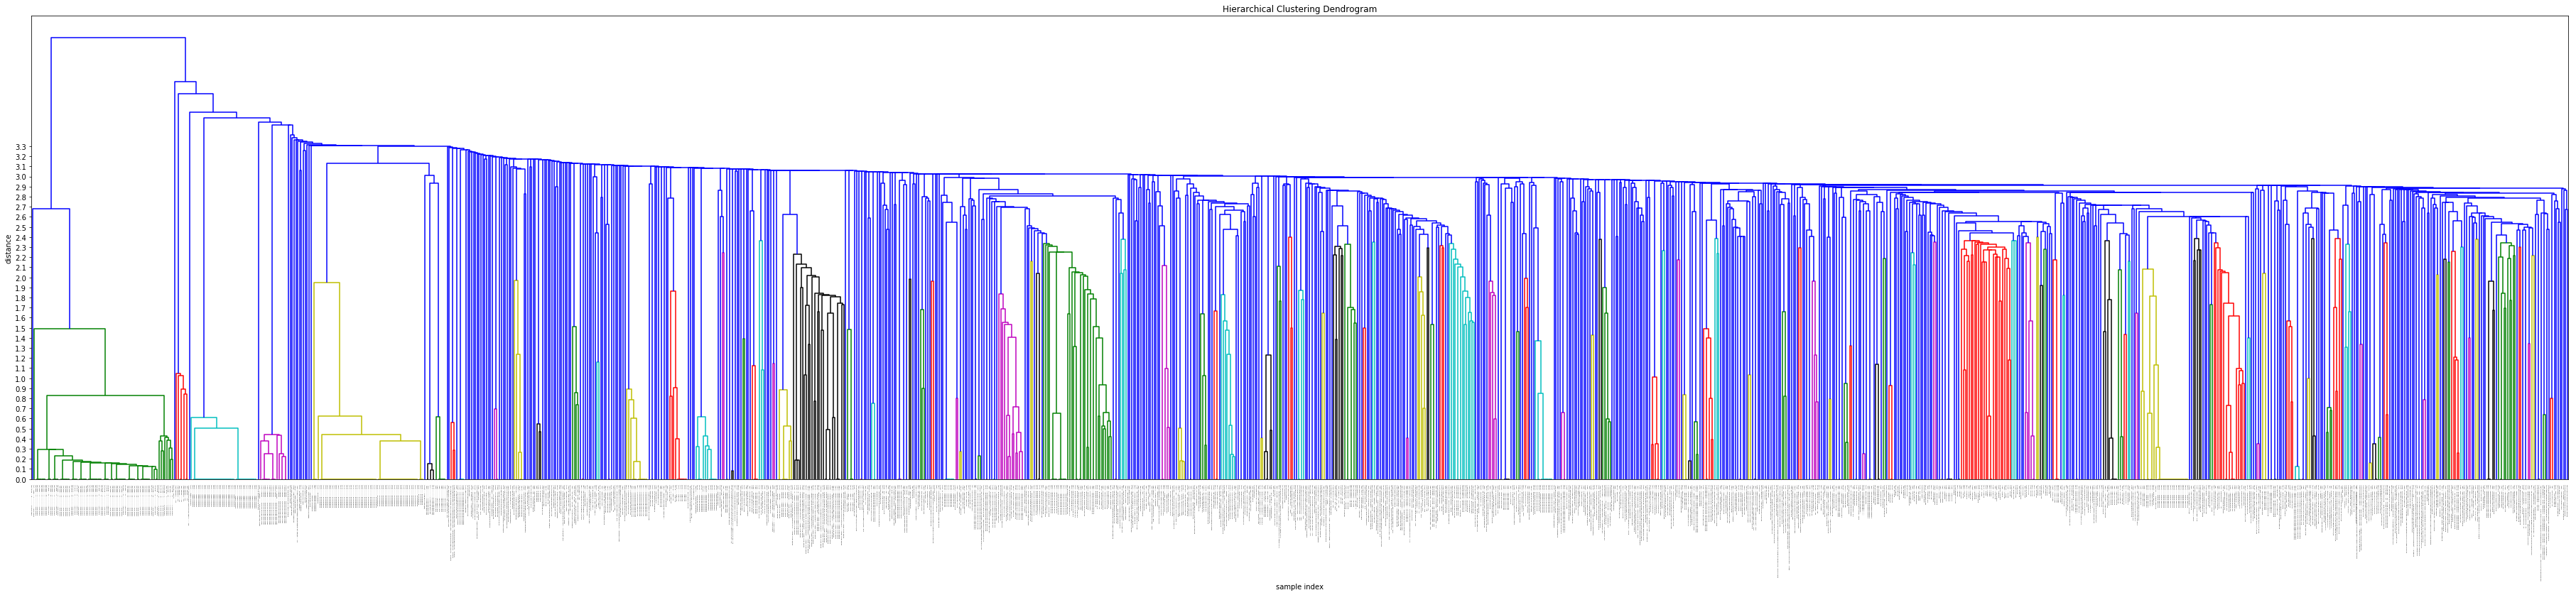

CPU times: user 52.6 s, sys: 11.9 s, total: 1min 4s
Wall time: 1min 3s


In [112]:
%%time
m = pickle.load(open('m.pkl', 'rb'))
plt.figure(figsize=(64, 12))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')

plt.yticks(np.arange(0, max(max([i for i in res['dcoord']])), 0.1))

plt.ylabel('distance')
# plt.yscale('log')
res = dendrogram(
    linkage(m),
    color_threshold=cluster_threshold
#    leaf_rotation=90.,  # rotates the x axis labels
#    leaf_font_size=8.,  # font size fora the x axis labels
)
pickle.dump(res, open('res.pkl', 'wb'))
plt.xticks(
    ticks=list(range(5, 10*len(data), 10)),
    labels=['{} ({})'.format(data[leave], leave) for leave in res['leaves']],
    fontsize=2
)
plt.savefig('dendogram.svg', bbox_inches='tight', pad_inches=.5)
plt.show()

In [113]:
res = pickle.load(open('res.pkl', 'rb'))

# Format as dict

In [114]:
clusters = defaultdict(list)

In [115]:
for cluster, gene in list(zip(clss, data)):
#    print(cluster, gene)
    clusters[cluster].append(gene)

In [116]:
clusters[750]

[]

In [117]:
def longestSubstring(str1,str2): 

    # initialize SequenceMatcher object with  
    # input string 
    seqMatch = SequenceMatcher(None,str1,str2) 

    # find match of longest sub-string 
    # output will be like Match(a=0, b=0, size=5) 
    match = seqMatch.find_longest_match(0, len(str1), 0, len(str2))

    # print longest substring 
    if (match.size!=0): 
        return (str1[match.a: match.a + match.size])  
    else: 
        print ('No longest common sub-string found') 
        return ''


# Get cluster name

In [118]:
from itertools import permutations 
  
# Get all permutations of [1, 2, 3] 
# Print the obtained permutations 
cluster_names = {}
for i in clusters.keys():
    cluster_name = ''
    if len(clusters[i]) == 1:
        cluster_name = clusters[i][0]
    for cluster_combi in list(permutations(clusters[i], 2)):
        lon_com = longestSubstring(*cluster_combi)
        if lon_com < cluster_name or cluster_name == '':
            cluster_name = lon_com
    cluster_names[i] = cluster_name.strip()

In [119]:
clusters[18]

['splicing factor, arginine/serine-rich ……A',
 'splicing factor, arginine/serine-rich …',
 'splicing factor, arginine/serine-rich …']

In [120]:
cluster_names[18]

'splicing factor, arginine/serine-rich …'

In [121]:
for gene, cls in zip(glds4, clss):
    gene['cluster'] = int(cls)
    gene['cluster_name'] = cluster_names[cls]

In [122]:
glds4[0]

{'Name': '0610007P14RIK',
 'Description': 'RIKEN cDNA 0610007P14 gene',
 'FLT1': 7.817609909,
 'FLT2': 8.259301845,
 'FLT3': 7.728688656,
 'FLT4': 8.227608089,
 'AEM1': 8.316221772,
 'AEM2': 8.254490447,
 'AEM3': 8.671204663,
 'AEM4': 8.596376001,
 'flight1': 0.075886102,
 'flight2': 0.023674024,
 'flight3': 0.086397417,
 'flight4': 0.027420519,
 'control1': -0.03844994,
 'control2': -0.030741525,
 'control3': -0.082776796,
 'control4': -0.073432911,
 'flightMean': 8.008303,
 'aemMean': 8.459574,
 'FvsAEM': -0.451271,
 'Description_mod': 'RIKEN cDNA …………………P…… gene',
 'cluster': 1,
 'cluster_name': 'RIKEN cDNA'}

In [123]:
json.dump(glds4, open('../nginx/web/data/glds4.json', 'w'), indent=4)

In [136]:
x = [i['flightMean'] for i in glds4]
y = [i['aemMean'] for i in glds4]
colors = [abs(i['flightMean'] - i['aemMean']) for i in glds4]

In [137]:
cmap = plt.cm.Blues

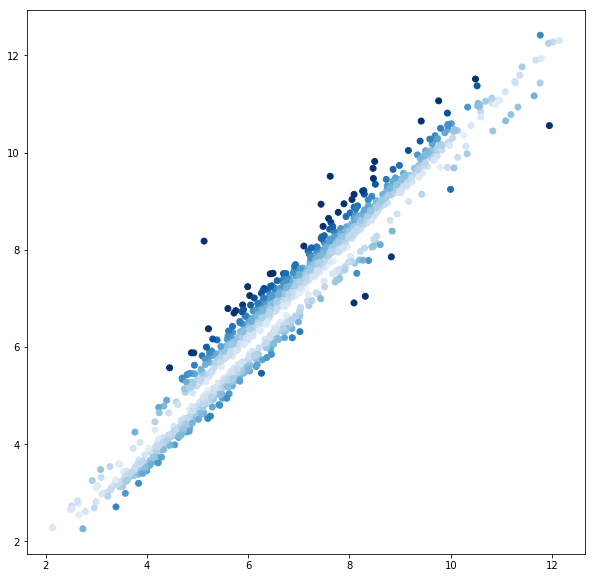

In [141]:
plt.figure(figsize=(10,10))
plt.scatter(x, y, color=cmap(colors))
plt.show()